In [1]:

import sys
sys.path.append('..')
from pymongo import MongoClient
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt

client = MongoClient(host='localhost')
__db = client['new_statistic']
user = __db['ptt_static.user']

# db = PttCrawlerMongoDB(only_connect_db=True)

In [2]:
df = pd.DataFrame(user.find({}))
# db.find('user', {})
# df = pd.read_json('./ptt_static.user.json')

In [3]:
df = df.drop('_id', axis=1)
df['len_act'] =  [len(row) for row in df['data']]
df['len_ip'] = [len(row) for row in df['ip']]
# df.to_json('./user_ip.json')
df.head()

,data,id,ip,tags,len_act,len_ip
0,"[{'board': 'Gossiping', 'text': '這樣台灣七成選民都是9.2...",z0953781935,"[39.9.130.238\n, 128.199.201.140\n]",83,142,2
1,"[{'board': 'Gossiping', 'text': '實話是這樣 不然為什麼台灣...",derayxu,[],3,3,0
2,"[{'board': 'Gossiping', 'text': '投不下去了', 'tag'...",energizer,[],2,8,0
3,"[{'board': 'Gossiping', 'text': '這不是實話嗎？ 噓文在崩潰...",cl700503,[],-2,10,0
4,"[{'board': 'Gossiping', 'text': '覺青要7pupu了', '...",k2233604,[],27,49,0


In [4]:
# 利用 IP 篩選正常使用者
mask = df['len_ip'] > 0 # 去除沒記錄到 ip 的
fair_user = df[mask]

# 分區段顯示過濾前資料
seg = np.arange(0, 100, 5)
df['ip_seg'] = pd.cut(df['len_ip'], seg)
df = df.dropna()
df.groupby('ip_seg').count()

,data,id,ip,tags,len_act,len_ip
ip_seg,,,,,,
"(0, 5]",4988,4988,4988,4988,4988,4988
"(5, 10]",226,226,226,226,226,226
"(10, 15]",51,51,51,51,51,51
"(15, 20]",15,15,15,15,15,15
"(20, 25]",9,9,9,9,9,9
"(25, 30]",4,4,4,4,4,4
"(30, 35]",2,2,2,2,2,2
"(35, 40]",1,1,1,1,1,1
"(40, 45]",0,0,0,0,0,0


In [5]:

# 計算離群值
q1 = fair_user['len_ip'].quantile(0.25)
q3 = fair_user['len_ip'].quantile(0.75)
iqr = q3 - q1

# 過濾離群值
mask1 = (fair_user['len_ip'] >= q1 - 1.5 * iqr) & (fair_user['len_ip'] 
                                                   <= np.ceil(q3 + 1.5 * iqr + 1))
fair_user = fair_user[mask1]

In [6]:
print(q1, q3)
print( q1 - 1.5 * iqr, np.ceil(q3 + 1.5 * iqr + 1))

1.0 2.0
-0.5 5.0


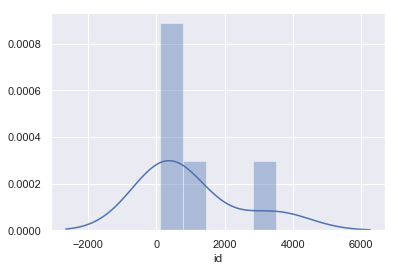

In [7]:
import seaborn as sns

sns.set()
# fair_user[mask1].groupby('len_ip')['id'].count().plot.kde()
# print(fair_user[mask1].groupby('len_ip').sum())

sns.distplot(fair_user.groupby('len_ip').count()['id'])

In [10]:
user_set = set(fair_user['id']) # 正常使用者的使用者名稱

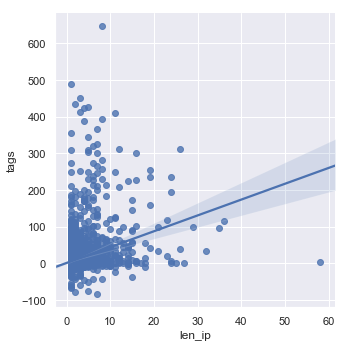

In [14]:
# 活動數量和IP數量關係
sns.lmplot(x='len_ip', y='tags', data=df)

In [15]:
df.corr()

,tags,len_act,len_ip
tags,1.000000,0.780832,0.307832
len_act,0.780832,1.000000,0.351688
len_ip,0.307832,0.351688,1.000000


In [16]:
fair_user.corr()

,tags,len_act,len_ip
tags,1.000000,0.725172,0.199573
len_act,0.725172,1.000000,0.223373
len_ip,0.199573,0.223373,1.000000


In [124]:
# 政黑版IP個數的平均數會大於母體平均數
hp_test = df[mask]
# hp_test['is_wrong'] = [0 if row['id'] in user_set else 1 for idx, row in hp_test.iterrows()]
# pop_mean = hp_test['len_ip'].sum() / len(hp_test)
pop_mean = fair_user['len_ip'].sum() / len(fair_user)
hp_n = 0 # count hp total
hp_wn = [] # count ip length

for r_idx, row in hp_test.iterrows():
    for data in row['data']:
        if data['board'] == 'HatePolitics':
            hp_n += 1
            hp_wn.append(row['len_ip'])
            break

hp_wn = pd.Series(hp_wn)
hp_mean = hp_wn.sum() / hp_n
std = hp_wn.std(ddof=1)

# sigma = hp_test['is_wrong'].std()
z = (hp_mean - pop_mean) / (std / np.sqrt(hp_n))

/anaconda3/envs/ptt_nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


45.552167895721496


In [125]:
print(hp_mean, z, pop_mean, std)
# print('population Mean: {}\n hate politics mean: {}\n population standar derivition: {}\n  z: {}'.format(pop_mean, hp_mean, sigma, z))

2.731566265060241 16.528409230274814 1.5136327185244587 3.3566154264869343
